In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import time
import os
import argparse
import matplotlib.pyplot as plt
# from tqdm import tqdm
from models.mae import *
from models.vae import *
import random

In [57]:
def data_normalize(scale, data):
    min_val = data.min()
    max_val = data.max()
    return scale * (data - min_val) / (max_val - min_val)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# V0_tensor = torch.tensor(np.load('Data/V/V_EIM0_64.npy'))
V1_tensor = torch.tensor(np.load('./data/V/V_EIM1_64.npy'))
V2_tensor = torch.tensor(np.load('./data/V/V_EIM2_64.npy'))
V3_tensor = torch.tensor(np.load('./data/V/V_EIM3_64.npy'))
V4_tensor = torch.tensor(np.load('./data/V/V_EIM4_64.npy'))
V5_tensor = torch.tensor(np.load('./data/V/V_EIM5_64.npy'))

# GT0_tensor = torch.tensor(np.load('Data/GT/GT0.npy'))
GT1_tensor = torch.tensor(np.load('./data/GT/GT1.npy'))
GT2_tensor = torch.tensor(np.load('./data/GT/GT2.npy'))
GT3_tensor = torch.tensor(np.load('./data/GT/GT3.npy'))
GT4_tensor = torch.tensor(np.load('./data/GT/GT4.npy'))
GT5_tensor = torch.tensor(np.load('./data/GT/GT5.npy'))

'''500*5 data'''
V_train = torch.cat((
        V1_tensor[0:500]
        ,V2_tensor[0:500]
        ,V3_tensor[0:500]
        ,V4_tensor[0:500]
        # ,V5_tensor[0:500]
    ), dim=0)
V_val = torch.cat((V1_tensor[-1500:-500]
                    , V2_tensor[-1500:-500]
                    , V3_tensor[-1500:-500]
                    , V4_tensor[-1500:-500]
                    , V5_tensor[-1500:-500]
                    ), dim=0)
V_test = torch.cat((V1_tensor[-500:]
                    , V2_tensor[-500:]
                    , V3_tensor[-500:]
                    , V4_tensor[-500:]
                    , V5_tensor[-500:]
                    ), dim=0)
GT_train = torch.cat((GT1_tensor[0:500]
                        , GT2_tensor[0:500]
                        , GT3_tensor[0:500]
                        , GT4_tensor[0:500]
                        , GT5_tensor[0:500]
                        ), dim=0)
GT_val = torch.cat((GT1_tensor[-1500:-500]
                    , GT2_tensor[-1500:-500]
                    , GT3_tensor[-1500:-500]
                    , GT4_tensor[-1500:-500]
                    , GT5_tensor[-1500:-500]
                    ), dim=0)
GT_test = torch.cat((GT1_tensor[-500:]
                    , GT2_tensor[-500:]
                    , GT3_tensor[-500:]
                    , GT4_tensor[-500:]
                    , GT5_tensor[-500:]
                    ), dim=0)


GT_train = data_normalize(scale=1, data=GT_train)
GT_val = data_normalize(scale=1, data=GT_val)
GT_test = data_normalize(scale=1, data=GT_test)


indices = np.arange(len(V_train))
np.random.shuffle(indices)

# apply the shuffled indices to V_train and GT_train
V_train = V_train[indices]
GT_train = GT_train[indices]
print(V_train.shape)
print(GT_train.shape)

torch.Size([2000, 1, 64, 64])
torch.Size([2000, 1, 48, 48])


In [62]:
ae_encoder = MAE_Encoder(mask_ratio=0.75)
ae_decoder = DeepVAE_Decoder()

# class Projection(nn.Module):
#     def __init__(self, input_dim=16640, hidden_dim1=4096, output_dim=128 * 6 * 6, dropout_rate=0.2):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim1),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_dim1, output_dim),
#         )
class Linear(nn.Module):
    def __init__(self, input_dim=16640, output_dim=128 * 6 * 6, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

    def forward(self, x):
        return self.layers(x)

class MLP_Projection(nn.Module):
    def __init__(
                    self, 
                    encoder=ae_encoder,
                    decoder=ae_decoder,
                    i_dim=16640,
                    hidden_dim1=4096,
                    o_dim=128 * 6 * 6,
                    dropout_rate=0.5,
                ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.projection = Linear(
                                    input_dim=i_dim,
                                    output_dim=o_dim,
                                    dropout_rate=dropout_rate
                                )
        self.flatten = nn.Flatten()

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        new_features = rearrange(features, 't b c -> b t c')
        # print('new_features:', new_features.shape)
        encoded = self.flatten(new_features)
        projected = self.projection(encoded)
        projected = projected.view(-1, 128, 6, 6)
        decoded = self.decoder(projected)
        normalized = torch.sigmoid(decoded)
        return normalized
        # return decoded
        
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  MLP_Projection().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=128, shuffle=False)
# model.load_state_dict(torch.load('Model/Finetune/finetune_img64_mlp_dvae_2500data.pth'), strict=False)
model.load_state_dict(torch.load('./results/Model/Finetune/finetune_img64_1layer_mlp_dvae_2500data_ep2000.pth'), strict=False)
model.eval()  
batch_size = 128
# test_outputs = model(V_test.to(device))
# test_loss = criterion(test_outputs, GT_test.to(device))

# print(f'Test Loss: {test_loss:.4f}')
num_batches = (len(V_test) + batch_size - 1) // batch_size
test_loss = 0.0
all_outputs = []  
with torch.no_grad():  
    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, len(V_test))
        
        batch_inputs = V_test[start:end].to(device)
        batch_targets = GT_test[start:end].to(device)
        
        test_outputs = model(batch_inputs)
        
        loss = criterion(test_outputs, batch_targets)
        
        test_loss += loss.item()
        
        all_outputs.append(test_outputs.cpu())  

test_loss /= num_batches
print(f'Test Loss: {test_loss:.8f}')

all_outputs = torch.cat(all_outputs, dim=0)  # combine all batches at dim=0

Test Loss: 0.01004695


pred max: 0.15908597
pred min: 0.00117364
label max: 0.25
label min: 0.0


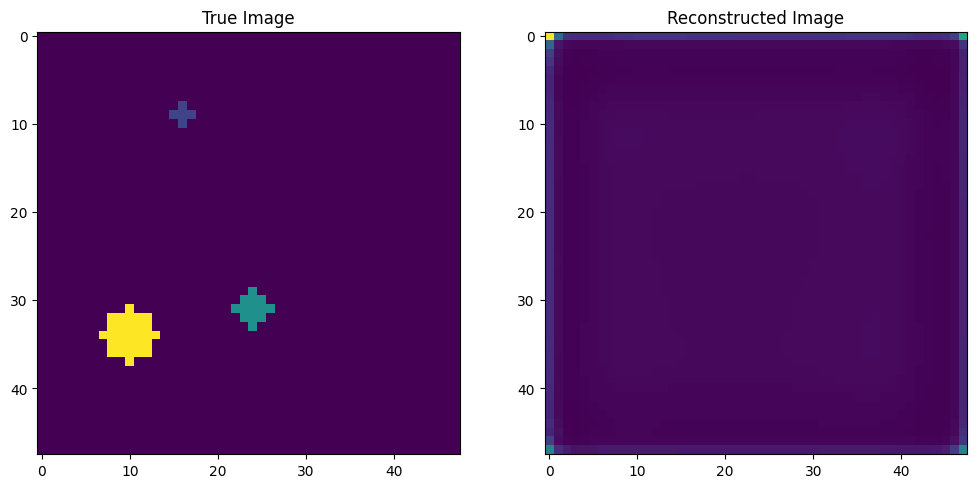

pred max: 0.1592074
pred min: 0.0011729543
label max: 1.0
label min: 0.0


<Figure size 640x480 with 0 Axes>

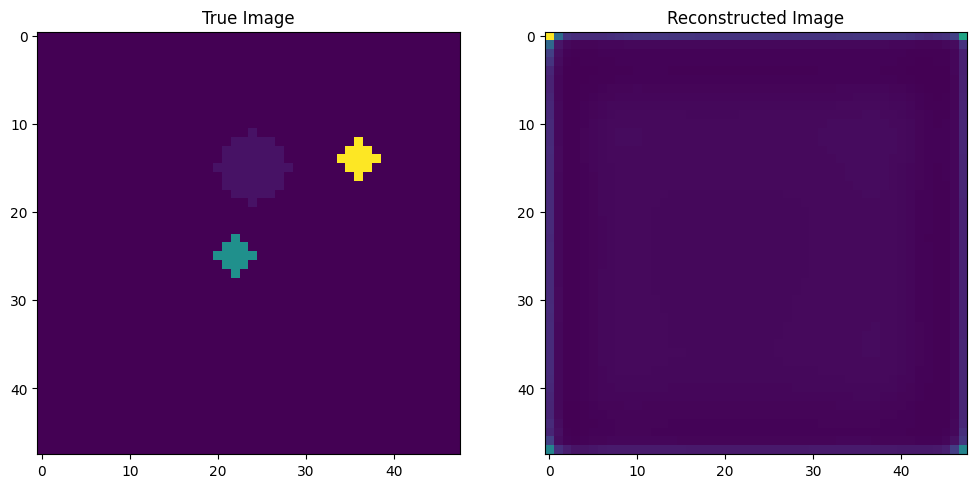

pred max: 0.15901628
pred min: 0.0011661196
label max: 0.25
label min: 0.0


<Figure size 640x480 with 0 Axes>

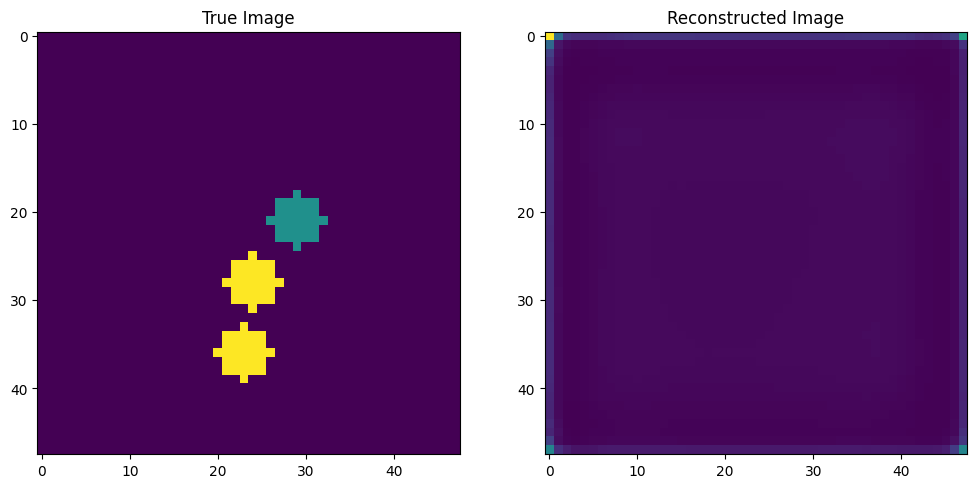

pred max: 0.15907082
pred min: 0.0011645261
label max: 0.25
label min: 0.0


<Figure size 640x480 with 0 Axes>

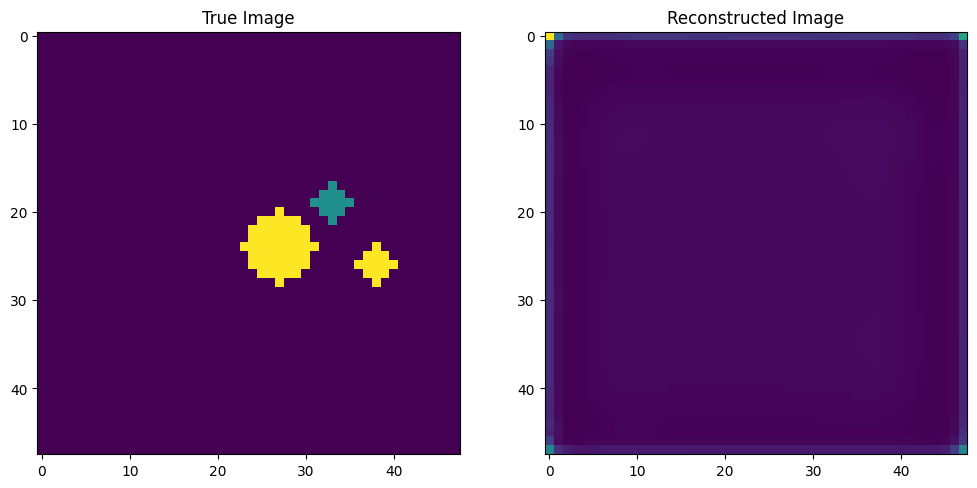

pred max: 0.15900975
pred min: 0.0011737591
label max: 0.25
label min: 0.0


<Figure size 640x480 with 0 Axes>

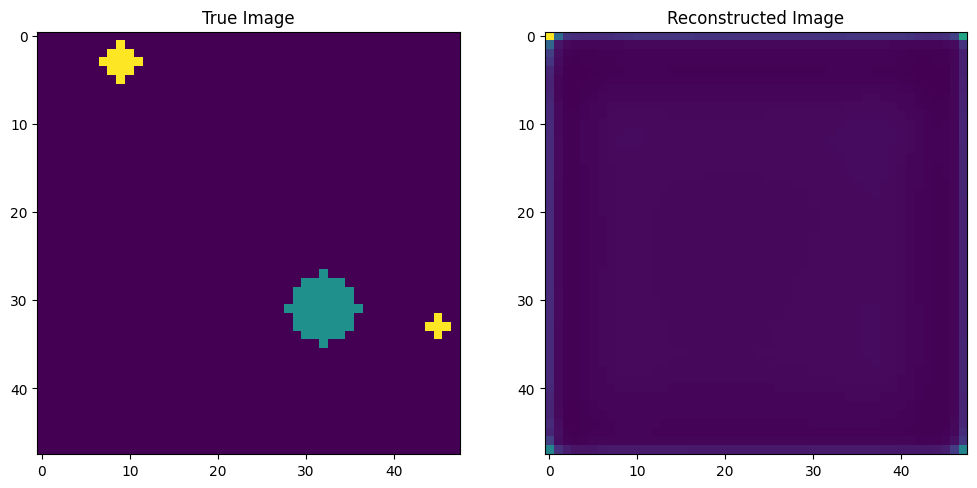

pred max: 0.15847622
pred min: 0.0011598356
label max: 1.0
label min: 0.0


<Figure size 640x480 with 0 Axes>

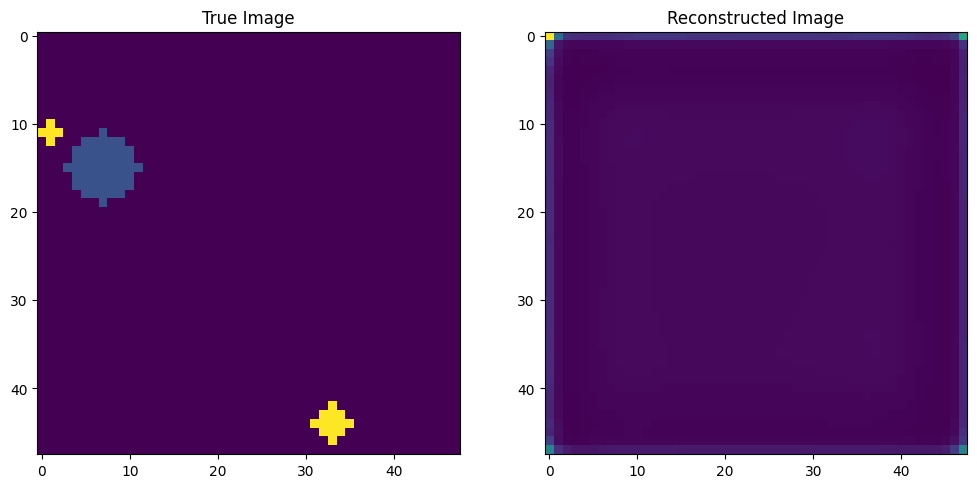

pred max: 0.1590467
pred min: 0.0011708451
label max: 0.25
label min: 0.0


<Figure size 640x480 with 0 Axes>

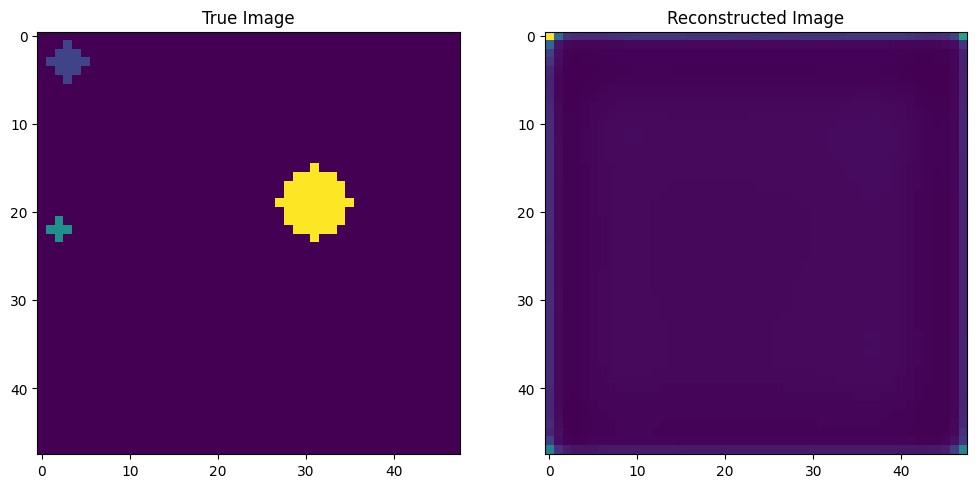

pred max: 0.15908088
pred min: 0.0011936375
label max: 0.5
label min: 0.0


<Figure size 640x480 with 0 Axes>

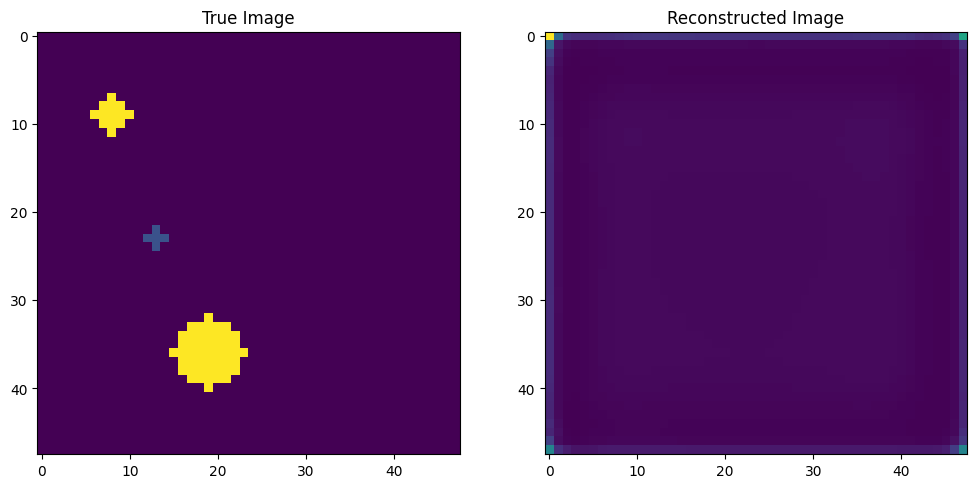

pred max: 0.15883021
pred min: 0.0011630589
label max: 0.125
label min: 0.0


<Figure size 640x480 with 0 Axes>

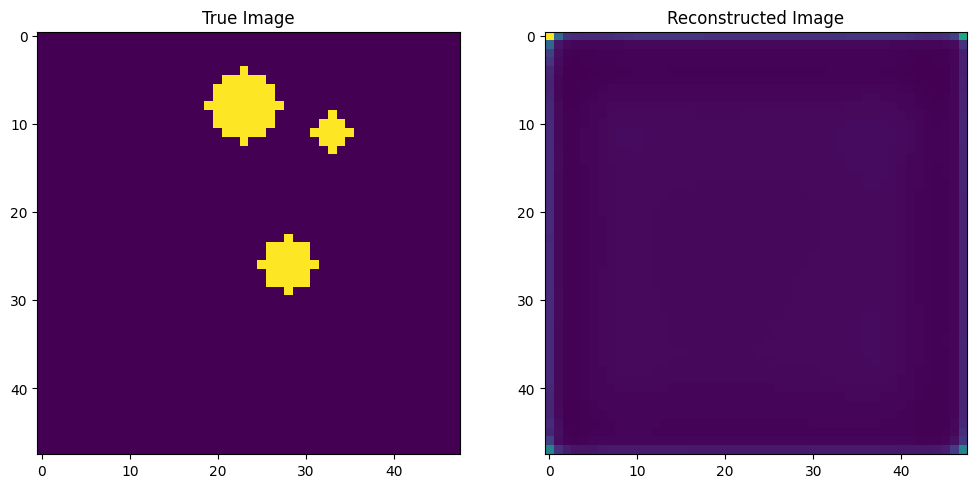

pred max: 0.15906891
pred min: 0.0011735053
label max: 0.5
label min: 0.0


<Figure size 640x480 with 0 Axes>

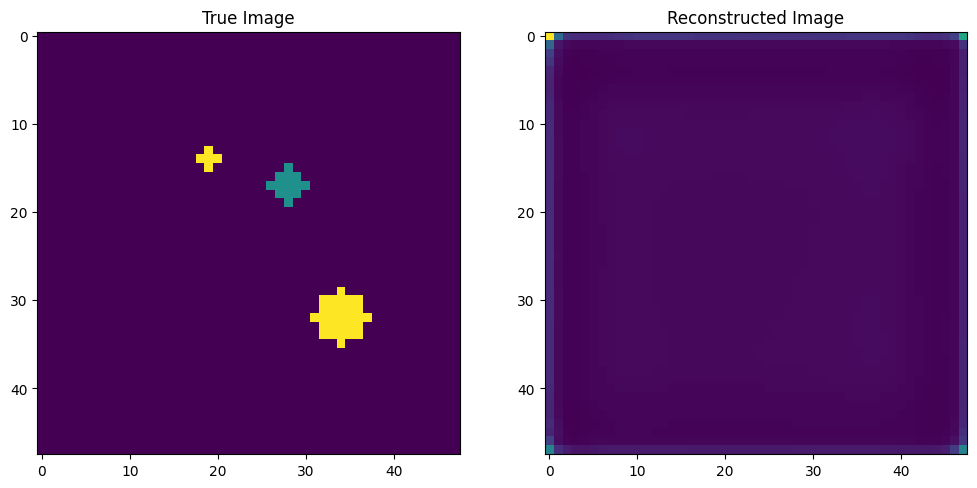

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.colors import Normalize

Pre_numpy = all_outputs.cpu().detach().numpy().reshape(2500, -1)
Label_numpy = GT_test.cpu().detach().numpy().reshape(2500, -1)

# np.savetxt('Result/Pre_FCNN_square.txt', Pre_numpy, fmt='%f')
# np.savetxt('Result/Label_FCNN_square.txt', Label_numpy, fmt='%f')

N = 1201
for idx in range(N,N+10):
    Prediction = all_outputs[idx]  
    # print all values in the tensor
    print('pred max:', max(Prediction.cpu().detach().squeeze().numpy().flatten()))
    print('pred min:', min(Prediction.cpu().detach().squeeze().numpy().flatten()))
    Label_test = GT_test[idx].squeeze()
    Label_test.shape
    print('label max:', max(Label_test.cpu().detach().squeeze().numpy().flatten()))
    print('label min:', min(Label_test.cpu().detach().squeeze().numpy().flatten()))

    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(Label_test, norm=Normalize())
    plt.title('True Image')
    # plt.colorbar()

    plt.subplot(1, 2, 2)
    # plt.imshow(Prediction.cpu().detach().squeeze().numpy(), norm=Normalize())
    plt.imshow(Prediction.cpu().detach().squeeze().numpy() )
    plt.title('Reconstructed Image')
    # plt.colorbar()
    plt.show()


    time.sleep(0.1)

    plt.clf()